In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from pathlib import Path
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func , inspect, and_

In [5]:
# Create a reference to the file. 
database_path = Path("../Resources/hawaii.sqlite")
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{database_path}").connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    primarykeystr = ""
    if column['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(column["name"],column["type"],primarykeystr)

id INTEGER Primary Key
station TEXT 
date TEXT 
prcp FLOAT 
tobs FLOAT 


In [11]:
columns = inspector.get_columns('station')
for column in columns:
    primarykeystr = ""
    if column['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(column["name"],column["type"],primarykeystr)

id INTEGER Primary Key
station TEXT 
name TEXT 
latitude FLOAT 
longitude FLOAT 
elevation FLOAT 


In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


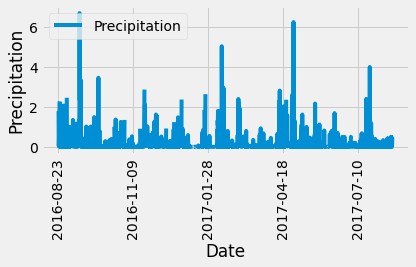

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
one_year_from_recent_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

last_12_months = session.query(Measurement.date , Measurement.prcp).filter(Measurement.date >= one_year_from_recent_date)

# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(last_12_months, columns=['Date','Precipitation'])
df.set_index('Date',  inplace=True)

# Sort the dataframe by date

df = df.sort_values(by='Date')
df.dropna()

# Use Pandas Plotting with Matplotlib to plot the data

df.plot(xlabel = 'Date', ylabel = 'Precipitation', rot = 90)
plt.tight_layout()


In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_seasons = session.query(Station.station).count()
print(total_seasons)

9


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations_list = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station = 'USC00519281'
temp_results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), \
                             func.avg(Measurement.tobs)).filter(Measurement.station == active_station).all()
temp_results                             

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 0, 'Temperature')

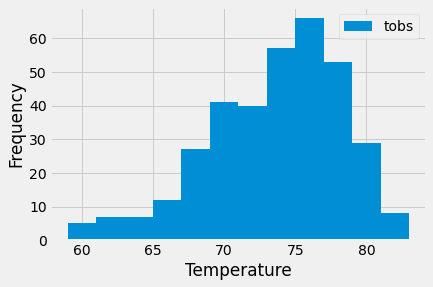

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12_months = session.query(Measurement.date, Measurement.tobs).\
    filter(and_(Measurement.date >= one_year_from_recent_date,
                Measurement.station == active_station)).all()
df_temp = pd.DataFrame(last_12_months)

df_temp.plot.hist(bins=12)
plt.xlabel('Temperature')

# Close Session

In [19]:
# Close Session
session.close()